In [ ]:
##############################################################################
## Fundamentals for pratical Text Analytics - document/word embeddings
##                                            more spacy, 
##                                            gensim to build our own ----> spacy
##                                            why:  dense numeric representations to capture meaning
##                                                  use downstream -> similarity, clustering, ML
##
##
## Learning goals:
##                 - continue spacy
##                 - foundational understanding of word vectors via Word2Vec
##                 - can roll our own vectors
##                 - generalized, pre-trained word vectors for S|UML tasks (intent classification)
##
##
## Great resources
##                 - https://spacy.io/usage/spacy-101
##                 - https://spacy.io/universe/category/courses
##
##
##############################################################################

In [ ]:
# installs
! pip install -U spacy 
! pip install -U textacy
! pip install newspaper3k
! pip install afinn
! pip install whatlies

In [2]:
# imports
import spacy
from spacy import cli
from spacy import displacy

import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, cdist, squareform
import seaborn as sns


# upcoming!
from textacy.extract.keyterms import textrank
import gensim

import textacy

from newspaper import Article
import json

from afinn import Afinn


In [3]:
# use spacy cli
MODEL = "en_core_web_md"

# https://spacy.io/models/en
cli.download(MODEL)

# nlp = language model
nlp = spacy.load(MODEL)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
############################################ WARMUP
##
##
## Scrape the Wikipedia Entry for the Netflix series Squid Game
## https://en.wikipedia.org/wiki/Squid_Game
##
## use the pre-loaded spacy NER model to parse the entities
## parse the entities into a dataframe
## create a barplot summarizing count by entity type
## TRICKY:  make it a horizontal barplot with the most frequent entity at the top of the chart
## 

In [9]:
URL = "https://en.wikipedia.org/wiki/Squid_Game"

# HINT:  we have seen how easy the newspaper3k package makes extracting data from the web!
article = Article(URL)
article.download()
article.parse()

In [10]:
article = article.text

In [11]:
# clean/remove the newline characters
# \n
article = article.replace("\n","")

In [12]:
doc = nlp(article)

In [19]:
ents_article = []

for e in doc.ents:
    ents_article.append((e.text, e.start_char,e.end_char,e.label_))
    
ents_article

[('2021', 0, 4, 'CARDINAL'),
 ('South Korean', 5, 17, 'NORP'),
 ('Netflix', 76, 83, 'ORG'),
 ('Korean', 111, 117, 'NORP'),
 ('Squids', 178, 184, 'NORP'),
 ('Game', 203, 207, 'PERSON'),
 ('Korean', 209, 215, 'NORP'),
 ('Geim', 238, 242, 'PERSON'),
 ('South Korean', 249, 261, 'NORP'),
 ('Hwang Dong-hyuk', 316, 331, 'PERSON'),
 ('Netflix', 336, 343, 'ORG'),
 ('Lee Jung-jae', 363, 375, 'PERSON'),
 ('Park Hae-soo', 377, 389, 'PERSON'),
 ('Wi Ha-joon', 391, 401, 'PERSON'),
 ('Jung Ho-yeon', 403, 415, 'PERSON'),
 ('O Yeong-su', 417, 427, 'PERSON'),
 ('Heo', 429, 432, 'NORP'),
 ('Anupam Tripathi', 443, 458, 'PERSON'),
 ('Kim Joo-ryoung', 464, 478, 'PERSON'),
 ('456', 522, 525, 'CARDINAL'),
 ('45.6', 661, 665, 'MONEY'),
 ('Korean', 737, 743, 'NORP'),
 ('Hwang', 761, 766, 'PERSON'),
 ('South Korea', 878, 889, 'GPE'),
 ('2009', 944, 948, 'DATE'),
 ('Netflix', 1016, 1023, 'ORG'),
 ('2019', 1048, 1052, 'DATE'),
 ('nine', 1127, 1131, 'CARDINAL'),
 ('Hwang', 1170, 1175, 'PERSON'),
 ('September 17, 20

In [20]:
df = pd.DataFrame(ents_article, columns=['text','start','end','entity'])

In [21]:
df.head()

,text,start,end,entity
0,2021,0,4,CARDINAL
1,South Korean,5,17,NORP
2,Netflix,76,83,ORG
3,Korean,111,117,NORP
4,Squids,178,184,NORP


In [22]:
counts = df.entity.value_counts()
counts

PERSON         225
ORG            163
CARDINAL       135
DATE           117
NORP            70
GPE             57
WORK_OF_ART     46
ORDINAL         33
TIME            10
MONEY            9
LOC              6
PRODUCT          6
PERCENT          5
FAC              4
LANGUAGE         4
EVENT            3
QUANTITY         3
LAW              2
Name: entity, dtype: int64

<AxesSubplot:>

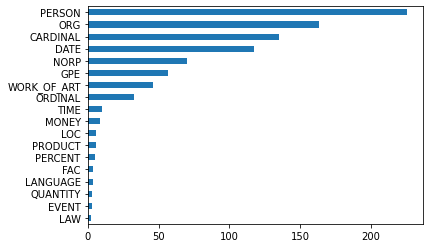

In [24]:
counts.sort_values().plot(kind='barh')

In [ ]:
############################################ Word/Doc Vectors
##
##

In [25]:
# lets review a simple document
tweet = 'That movie from email@email.com was 🔥! We can review it at www.bu.edu.'

In [26]:
# spacy is a pipeline
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [28]:
doc = nlp(tweet)
doc

That movie from email@email.com was 🔥! We can review it at www.bu.edu.

In [29]:
# remember, we can slice up docs into tokens/spans
token = doc[0]
token

That

In [30]:
type(token)

spacy.tokens.token.Token

In [31]:
token.is_alpha

True

In [ ]:
# tokens have all sorts of attributes that were learned


In [ ]:
# worth noting, a document can be comprised of sentences
# remember that we used to download punkt from nltk?
# that was a sentence tokenizer (divide into sentences)
# spacy has this built in


In [ ]:
####################################### quick departure
# above we checked against spacy's learned vocabulary
# this is a check to see if a token is out-of-vocabulary (OOV)

# model reviews:
# https://spacy.io/usage/models


In [32]:
# this is just for reference
# 

v = nlp.vocab.vectors
v.shape

(20000, 300)

In [34]:
# spacy stores text and tokens effeciently 
# https://spacy.io/usage/spacy-101#vocab

# spacy provides a way to lookup the vectors
nlp.vocab.strings["golf"]

# and we can reverse
nlp.vocab.strings[18149141486079540445]

## spacy is very flexible, and while vectors can be added and edited, 
## we can just include our own, which we will do later

'golf'

In [ ]:
#######################################  Vectors/Embeddings
##
## You have heard me use this term quite a bit
## we have seen this via PCA ----> take a large feature space and re-represent this in a new space
##     the goal was to encode information and reduce noise, right?
##
## we saw this in Tsne (2 embeddings) and UMAP (can be 2 or more depending on our needs)
## 
## 
## Well in text, we have the same idea
## we could always use the tools above, but there this is a "hot" field right now -> embeddings




![](https://miro.medium.com/max/2224/0*K5a1Ws_nsbEjhbYk.png)

> Above we can see words can be represented in these highly dimensional spaces.  The aim is to encapsulate context.  Remember bag-of-words removes sequence/order!


![](https://jalammar.github.io/images/word2vec/king-analogy-viz.png)

![](https://miro.medium.com/max/1400/1*cuOmGT7NevP9oJFJfVpRKA.png)


In [54]:
# get some vectors

king = nlp("king").vector
man = nlp("man").vector
woman = nlp("woman").vector
queen = nlp("queen").vector
jester = nlp("jester").vector
court = nlp("court").vector
golf = nlp("golf").vector

In [55]:
# what do we have
king.shape

(300,)

In [56]:
# a quick preview
king[:5]

array([ 0.31542, -0.35068,  0.42923, -0.53825, -0.1848 ], dtype=float32)

In [57]:
# some math
test = king - man + woman
test[:5]

array([ 0.514087  , -0.27846   ,  0.242767  ,  0.04548997, -0.259425  ],
      dtype=float32)

In [58]:
# the comparison set

lookups = np.stack([queen, jester, court, golf])
lookups.shape

(4, 300)

In [59]:
# we can use cdist manually
comp_list = ['queen', 'jester', 'court', 'golf']

# the test calc needs to be 2-d
test = np.expand_dims(test, 0)

test.shape

(1, 300)

In [60]:
# the comps -- cdist expected test to be 2d, so we used expand dims above
comps = cdist(test, lookups, metric="cosine")

<AxesSubplot:>

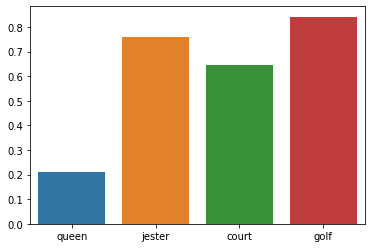

In [61]:
# lets plot the distances as a barplot
sns.barplot(x=comp_list, y=comps[0])


In [ ]:
# so what did we see
# it was a small test, but conceptually we saw how these vectors can be compared
# we used distance to compare the numeric vectors and manually find the most similar
# contrived example, but sets up the concepts

In [ ]:
# there are some great toolkits that have been created
# to breakdown and explore all sorts of embeddings

# lots you can do here, but from some of the dev rel folks at rasa, which
# we will briefly see next class!
# https://github.com/RasaHQ/whatlies

In [62]:
## let's go back to the tweet
doc

That movie from email@email.com was 🔥! We can review it at www.bu.edu.

In [63]:
[(token.text, token.is_oov) for token in doc]

[('That', False),
 ('movie', False),
 ('from', False),
 ('email@email.com', True),
 ('was', False),
 ('🔥', True),
 ('!', False),
 ('We', False),
 ('can', False),
 ('review', False),
 ('it', False),
 ('at', False),
 ('www.bu.edu', True),
 ('.', False)]

In [64]:
fire = nlp('🔥')

In [65]:
# get the vectors
fire.vector

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [66]:
# what do we get for a token that is OOV? -- out of vocabulary

nlp('🔥').vector

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
## what do you notice?
## this is a convention of spacy
## for OOV tokens, spacy doesn't fail, it simply returns an array of zeroes

In [70]:
dv = doc.vector

In [71]:
# how do we think the doc vector is constructed?
vecs = []
for token in doc:
  vecs.append(token.vector)

# make it a numpy array
va = np.array(vecs)

vam = va.mean(axis=0)
vam.shape

# compare
np.all(vam == dv)

True

In [ ]:
# remember spans?
# same still applies - token vectors are averaged over the docs and spans to represent the document

In [ ]:
#######################################  YOUR TURN
## 
## scrape the text from the three articles from the URLs below
## generate the doc vectors
## what is the most similar article to URL1 via cosine distance?
#
# URL1 = "https://www.boston.com/weather/weather/2021/11/26/boston-ma-snow-forecast-friday-nov-26-2021/"
# URL2 = "https://www.sportingnews.com/us/fantasy/news/nfl-week-12-weather-updates-lack-of-rain-wind-snow-in-forecast-eases-fantasy-football-start-em-sit-em-decisions/lueadzpkttxa1l2nzyr70hr18"
# URL3 = "https://www.marketwatch.com/story/the-u-s-stock-market-suffers-ugly-black-friday-selloff-here-are-the-biggest-losers-and-winners-11637952898"
## 


In [ ]:
#######################################  UP NEXT
## 
## Team data challenge!
# 